<a href="https://colab.research.google.com/github/marco-siino/T100-PAN2022/blob/main/T100_SVM_LR_ISS2022_MLC_CrossPredictions_ModelNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing modules.

In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn import naive_bayes,svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from google.colab import files
from io import open
from pathlib import Path

## Importing DS and extract in current working directory.

In [ ]:
# Url obtained starting from this: https://drive.google.com/file/d/19ZcqEv88euKB71HfAWjTGN3uCKp2qsfP/ and forcing export=download.
train_set_url = "https://github.com/marco-siino/iss/raw/main/pan22-author-profiling-training-2022-03-29-augmented.zip"
test_set_url="https://github.com/marco-siino/iss/raw/main/pan22-author-profiling-test-2022-04-22-without_truth-augmented.zip"

train_set_path = tf.keras.utils.get_file("pan22-author-profiling-training-2022-03-29-augmented.zip", train_set_url,
                                    extract=True, archive_format='zip',cache_dir='.',
                                    cache_subdir='')
test_set_path = tf.keras.utils.get_file("pan22-author-profiling-test-2022-04-22-without_truth-augmented.zip", test_set_url,
                                  extract=True, archive_format='zip',cache_dir='.',
                                  cache_subdir='')

train_set_dir = os.path.join(os.path.dirname(train_set_path), 'pan22-author-profiling-training-2022-03-29-augmented')
test_set_dir = os.path.join(os.path.dirname(test_set_path), 'pan22-author-profiling-test-2022-04-22-without_truth-augmented')

print(train_set_path)
print(train_set_dir)

!ls -A

4169728/4154540 [==============================] - 0s 0us/step
./pan22-author-profiling-training-2022-03-29-augmented.zip
./pan22-author-profiling-training-2022-03-29-augmented
.config
pan22-author-profiling-test-2022-04-22-without_truth-augmented
pan22-author-profiling-test-2022-04-22-without_truth-augmented.zip
pan22-author-profiling-training-2022-03-29-augmented
pan22-author-profiling-training-2022-03-29-augmented.zip
sample_data


## Build folders hierarchy to use Keras folders preprocessing function.

In [ ]:
### Training Folders. ###
# First level directory.
if not os.path.exists('train_dir'):
    os.makedirs('train_dir')

# Class labels directory.
if not os.path.exists('train_dir/0'):
    os.makedirs('train_dir/0')
if not os.path.exists('train_dir/1'):
    os.makedirs('train_dir/1')

!ls -A

.config
pan22-author-profiling-test-2022-04-22-without_truth-augmented
pan22-author-profiling-test-2022-04-22-without_truth-augmented.zip
pan22-author-profiling-training-2022-03-29-augmented
pan22-author-profiling-training-2022-03-29-augmented.zip
sample_data
train_dir


## Set language and directory paths.


In [ ]:
# Set train_dir and test_dir paths.
#truth_file_test_dir=test_set_dir

truth_file_train_dir=train_set_dir+'/'
truth_file_training_path = truth_file_train_dir+'en.txt'

#truth_file_test_path_en = truth_file_test_dir+'/'+language+'.txt'

## Read truth.txt to organize training dataset folders.



In [ ]:
# Open the file truth.txt with read only permit.
f = open(truth_file_training_path, "r")
# use readline() to read the first line 
line = f.readline()
# use the read line to read further.
# If the file is not empty keep reading one line
# at a time, till the file is empty
while line:
    # Split line at :::
    x = line.split(":::")
    fNameXml = x[0]+'.xml'
    fNameTxt = x[0]+'.txt'
    # Second coord [0] gets just the first character (label) and not /n too.
    label = x[1][0]
    # Change Classes NI->0 and I->1.
    if (label=='I'):
      label=1
    else:
      label=0
   
    # Now move the file to the right folder.
    if os.path.exists(truth_file_train_dir+'en/'+fNameXml):
      os.rename(truth_file_train_dir+'en/'+fNameXml, './train_dir/'+str(label)+'/'+fNameTxt )

    # use readline() to read next line
    line = f.readline()

## Building the dataset.

In [ ]:
batch_size=1  

full_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'train_dir', 
    batch_size=batch_size, 
    shuffle=False,
    seed=1
    )

full_train_ds=full_train_ds.shuffle(420,seed=1, reshuffle_each_iteration=False)
full_train_ds_size=len(full_train_ds)

Found 420 files belonging to 2 classes.


## First model's layer: Text Vectorization.

In [ ]:
# Function to generate a text_vectorization_layer.
def gen_text_vectorization_layer(train_set):
    # Set a very large sequence length to find the longest sample.
    sequence_length = 30000
    vectorize_layer_tmp = TextVectorization(
        standardize=None,
        output_mode='int',
        output_sequence_length=sequence_length)

    train_text = train_set.map(lambda x, y: x)
    vectorize_layer_tmp.adapt(train_text)
    #vectorize_layer.get_vocabulary()

    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
    model.add(vectorize_layer_tmp)

    longest_sample_length=1
    max_nr_dictionary_entry = 1

    for element in train_set:
      authorDocument=element[0]
      label=element[1]
      
      #print("Sample considered is: ", authorDocument[0].numpy())
      #print("Preprocessed: ", str(custom_standardization(authorDocument[0].numpy())))
      #print("And has label: ", label[0].numpy())

      # Count the number of zeros from the last non-zero token to the end of the sample. 
      # Shortest tokenized sample has less zeros than others.
      out=model(authorDocument)
      token_nr_index=sequence_length-1
      current_sample_zeros_counter=0
      while out.numpy()[0][token_nr_index]==0:
        token_nr_index-=1
        current_sample_zeros_counter+=1

      shortest_padding_length=sequence_length-longest_sample_length
      if current_sample_zeros_counter<shortest_padding_length:
        longest_sample_length=sequence_length-current_sample_zeros_counter

      # Get greater token value (to set dictionary size) for current sample.
      if np.amax(out.numpy()[0])>max_nr_dictionary_entry:
        max_nr_dictionary_entry=np.amax(out.numpy()[0])

    # Be sure to include each ngram.
    max_nr_dictionary_entry+=1

    print("Length of the longest sample in train set is:",longest_sample_length)
    print("Dictionary size is:",max_nr_dictionary_entry)

    sequence_length = longest_sample_length

    vectorize_layer = TextVectorization(
        standardize=None,
        max_tokens=max_nr_dictionary_entry,
        output_mode='int',
        output_sequence_length=sequence_length)
    train_text = train_set.map(lambda x, y: x)
    vectorize_layer.adapt(train_text)
    
    return vectorize_layer,max_nr_dictionary_entry

## Split the full training set to do a 5-cross fold validation.




In [ ]:
# 5 Cross fold generation example. 

# 1° Fold -> 80% - 20%V
# 2° Fold -> 60% - 20%V - 20%
# 3° Fold -> 40% - 20%V - 40%
# 4° Fold -> 20% - 20%V - 60%
# 5° Fold -> 20%V - 80%

train = []
val = []
test = []

# train_ds = train+val. DS used for model development.
full_train_ds_size = len(full_train_ds)
train_ds = full_train_ds.take(380)
# Final set to be used at the end of development phase. A little less than 10% of the original ds (420 samples).
test_set = full_train_ds.skip(380)
"""
        380           40        TOT = 420
|_________________| |_____|
      train_ds      test_set
"""

# Percentage start and end of validation subset within train_ds. (at each fold: train->304 samples, val->76 samples)
val_percentage_start=80
val_percentage_end=100
val_percentage_size=20
fold_nr=5

for i in range(0,fold_nr):
  train.append(train_ds.take(int(len(train_ds)*val_percentage_start/100)))
  train[i] = train[i].concatenate(train_ds.skip(int(len(train_ds)*val_percentage_end/100)))

  val.append(train_ds.skip(int(len(train_ds)*val_percentage_start/100)))
  val[i] = val[i].take(int(len(train_ds)*val_percentage_size/100))

  val_percentage_start-=val_percentage_size
  val_percentage_end-=val_percentage_size

## CNN model definition and training.

In [ ]:
# Word embedding dimensions.
embedding_dim = 100
cnn = []
max_features = []

cnn_preds_results =[]

for current_fold in range(0,fold_nr):
  print("\n\nFold nr.: ", current_fold)

  vectorize_layer, max_features_tmp = gen_text_vectorization_layer(train[current_fold])
  max_features.append(max_features_tmp)

  cnn.append(tf.keras.Sequential([
                              tf.keras.Input(shape=(1,), dtype=tf.string),
                              vectorize_layer,
                              layers.Embedding(max_features[current_fold] + 1, embedding_dim),                     
                              layers.Dropout(0.4),

                              layers.Conv1D(64,16),
                              layers.MaxPooling1D(),
                              layers.Dropout(0.5),                 
                              
                              layers.GlobalAveragePooling1D(),
                              layers.Dense(1)
    ]))

  opt = tf.keras.optimizers.Adam()
  cnn[current_fold].compile(loss=losses.BinaryCrossentropy(from_logits=True), optimizer=opt, metrics=tf.metrics.BinaryAccuracy(threshold=0.0)) 

  epochs = 5
  history = cnn[current_fold].fit(
      train[current_fold],
      validation_data=val[current_fold],
      epochs=epochs,
      shuffle=False,
      # Comment the following line to do not save and download the model.
      #callbacks=[callbacks]
      )
  
  cnn_preds_results.append(cnn[current_fold].evaluate(val[current_fold])[1])
  print("AVG accuracy on Val and Test set is:", str((cnn[current_fold].evaluate(test_set)[1]+cnn[current_fold].evaluate(val[current_fold])[1])/2))
  #model_en.summary()
print("\n\n******************************************************")
print("\n\nOver five folds AVG accuracy is:", str(sum(cnn_preds_results)/fold_nr))



Fold nr.:  0
Length of the longest sample in train set is: 20382
Dictionary size is: 165944
Epoch 1/5
304/304 [==============================] - 19s 21ms/step - loss: 0.6780 - binary_accuracy: 0.5493 - val_loss: 0.5236 - val_binary_accuracy: 0.7763
Epoch 2/5
304/304 [==============================] - 6s 21ms/step - loss: 0.3193 - binary_accuracy: 0.8816 - val_loss: 0.3951 - val_binary_accuracy: 0.8026
Epoch 3/5
304/304 [==============================] - 7s 21ms/step - loss: 0.0743 - binary_accuracy: 0.9737 - val_loss: 0.2642 - val_binary_accuracy: 0.8947
Epoch 4/5
304/304 [==============================] - 8s 25ms/step - loss: 0.0159 - binary_accuracy: 0.9967 - val_loss: 0.3239 - val_binary_accuracy: 0.9079
Epoch 5/5
76/76 [==============================] - 1s 7ms/step - loss: 0.3271 - binary_accuracy: 0.8947
AVG accuracy on Val and Test set is: 0.8973684012889862


Fold nr.:  1
Length of the longest sample in train set is: 20382
Dictionary size is: 165152
Epoch 1/5
304/304 [========

## Train and predict with Naive Bayes, SVM and Decision Tree.

In [ ]:
# Train, test and val split list samples.
train_labels=[]
train_samples=[]
val_labels=[]
val_samples=[]
test_labels = []
test_samples = []

# Models for each fold.
SVM = []
NB = []
DT = []

for current_fold in range(0,fold_nr):
    train_labels.append([])
    train_samples.append([])
    val_labels.append([])
    val_samples.append([])
    test_labels.append([])
    test_samples.append([])
    print("\n\nFold nr.:", current_fold)
    for element in train[current_fold]:
      authorDocument=element[0]
      label=element[1]
      
      text_vect_layer_model = tf.keras.Model(inputs=cnn[current_fold].input,
                                          outputs=cnn[current_fold].get_layer(cnn[current_fold].get_layer(index=0).name).output)
      text_vect_out = text_vect_layer_model(authorDocument)

      train_labels[current_fold].append(label[0].numpy())
      current_sample = np.zeros(max_features[current_fold])
      for current_token in text_vect_out[0][:].numpy():
        #print(current_token,end=' ')
        #print(vectorize_layer.get_vocabulary()[current_token])
        current_sample[current_token]+=1
      train_samples[current_fold].append(current_sample)      

    train_labels[current_fold] = np.array(train_labels[current_fold])
    train_samples[current_fold] = np.array(train_samples[current_fold])
    #print("\nLE LABELS DEI CAMPIONI DI TRAINING SONO:")
    #print(training_labels)
    #print("\nI SAMPLE DI TRAINING DOPO LA TEXT VECTORIZATION SONO:")
    #print(training_samples)

    NB.append(MultinomialNB())
    NB[current_fold].fit(train_samples[current_fold], train_labels[current_fold])
    print("\nNaive Bayes Accuracy on Training set -> ",NB[current_fold].score(train_samples[current_fold],train_labels[current_fold]))

    SVM.append(svm.SVC(C=0.5, kernel='linear', gamma='auto', probability=True))
    SVM[current_fold].fit(train_samples[current_fold],train_labels[current_fold])
    print("SVM Accuracy Score on Training set -> ",SVM[current_fold].score(train_samples[current_fold],train_labels[current_fold]))

    DT.append(DecisionTreeClassifier(random_state=0))
    DT[current_fold].fit(train_samples[current_fold], train_labels[current_fold])
    print("Decision Tree Accuracy on Training set -> ",DT[current_fold].score(train_samples[current_fold],train_labels[current_fold]))

    for element in val[current_fold]:
      authorDocument=element[0]
      label=element[1]
      
      text_vect_out = text_vect_layer_model(authorDocument)

      val_labels[current_fold].append(label[0].numpy())
      current_sample=np.zeros(max_features[current_fold])
      for current_token in text_vect_out[0][:].numpy():
        current_sample[current_token]+=1
      val_samples[current_fold].append(current_sample)

    val_labels[current_fold] = np.array(val_labels[current_fold])
    val_samples[current_fold] = np.array(val_samples[current_fold])

    print("\nNaive Bayes Accuracy on Val set -> ",NB[current_fold].score(val_samples[current_fold],val_labels[current_fold]))
    print("SVM Accuracy Score on Val set -> ",SVM[current_fold].score(val_samples[current_fold],val_labels[current_fold]))
    print("DT Accuracy Score on Val set -> ",DT[current_fold].score(val_samples[current_fold],val_labels[current_fold]))

    for element in test_set:
      authorDocument = element[0]
      label = element[1]
      
      text_vect_out = text_vect_layer_model(authorDocument)

      test_labels[current_fold].append(label[0].numpy())
      current_sample=np.zeros(max_features[current_fold])
      for current_token in text_vect_out[0][:].numpy():
        current_sample[current_token]+=1
      test_samples[current_fold].append(current_sample)

    test_labels[current_fold] = np.array(test_labels[current_fold])
    test_samples[current_fold] = np.array(test_samples[current_fold])

    print("\nNaive Bayes Accuracy on Test set -> ",NB[current_fold].score(test_samples[current_fold],test_labels[current_fold]))
    print("SVM Accuracy Score on Test set -> ",SVM[current_fold].score(test_samples[current_fold],test_labels[current_fold]))
    print("DT Accuracy Score on Test set -> ",DT[current_fold].score(test_samples[current_fold],test_labels[current_fold]))

    print("\nNaive Bayes AVG Accuracy on Val and Test set -> ",(NB[current_fold].score(test_samples[current_fold],test_labels[current_fold])+NB[current_fold].score(val_samples[current_fold],val_labels[current_fold]))/2)
    print("SVM AVG Accuracy Score on Val and Test set -> ",(SVM[current_fold].score(test_samples[current_fold],test_labels[current_fold])+SVM[current_fold].score(val_samples[current_fold],val_labels[current_fold]))/2)
    print("DT AVG Accuracy Score on Val and Test set -> ",(DT[current_fold].score(test_samples[current_fold],test_labels[current_fold])+DT[current_fold].score(val_samples[current_fold],val_labels[current_fold]))/2)
    print("\n****************************************************")
    # ****************************************************



Fold nr.: 0

Naive Bayes Accuracy on Training set ->  0.993421052631579
SVM Accuracy Score on Training set ->  1.0
Decision Tree Accuracy on Training set ->  1.0

Naive Bayes Accuracy on Val set ->  0.8947368421052632
SVM Accuracy Score on Val set ->  0.9210526315789473
DT Accuracy Score on Val set ->  0.7368421052631579

Naive Bayes Accuracy on Test set ->  0.9
SVM Accuracy Score on Test set ->  0.875
DT Accuracy Score on Test set ->  0.775

Naive Bayes AVG Accuracy on Val and Test set ->  0.8973684210526316
SVM AVG Accuracy Score on Val and Test set ->  0.8980263157894737
DT AVG Accuracy Score on Val and Test set ->  0.7559210526315789

****************************************************


Fold nr.: 1

Naive Bayes Accuracy on Training set ->  0.993421052631579
SVM Accuracy Score on Training set ->  1.0
Decision Tree Accuracy on Training set ->  1.0

Naive Bayes Accuracy on Val set ->  0.8552631578947368
SVM Accuracy Score on Val set ->  0.9342105263157895
DT Accuracy Score on Val 

## Generating classifiers Prediction using MLC Cross!

In [ ]:
#f = open("preds.txt", "a")

prediction_ds=[]

# The prediction_ds is built predicting on each val[fold] using the models trained on the corresponding train[fold].
for current_fold in range((fold_nr-1),-1,-1):
    print("Fold nr.:", current_fold)
    #f.write(("Fold nr.:"+str(current_fold)))
    for element in val[current_fold]:
      authorDocument=element[0]
      label=element[1]

      text_vect_layer_model = tf.keras.Model(inputs=cnn[current_fold].input,
                                          outputs=cnn[current_fold].get_layer(cnn[current_fold].get_layer(index=0).name).output)
      text_vect_out = text_vect_layer_model(authorDocument)

      current_sample = np.zeros(max_features[current_fold])
      for current_token in text_vect_out[0][:].numpy():
        current_sample[current_token]+=1
      
      cnn_prediction = cnn[current_fold].predict(element[0])
      
      prediction_ds.append([cnn_prediction[0][0],
                        NB[current_fold].predict_proba(current_sample.reshape(1,-1))[0][0],NB[current_fold].predict_proba(current_sample.reshape(1,-1))[0][1],
                        SVM[current_fold].predict_proba(current_sample.reshape(1,-1))[0][0],SVM[current_fold].predict_proba(current_sample.reshape(1,-1))[0][1],
                        DT[current_fold].predict_proba(current_sample.reshape(1,-1))[0][0],DT[current_fold].predict_proba(current_sample.reshape(1,-1))[0][1],
                        label[0].numpy()])

      #print("Sample ",sample_nr," -> CNN Predicts: ",cnn_prediction," -> NB Predicts: ",clf.predict(current_sample.reshape(1,-1))[0]," SVM Predicts:",SVM.predict(current_sample.reshape(1,-1))[0],"Actual: ", label[0].numpy())
      #sample_nr+=1

# To generate the prediction on the test set we use the best performing model over the 5 folds (the fourth one -> 2 fold)
best_fold = 2
current_fold = best_fold
for element in test_set:
      authorDocument=element[0]
      label=element[1]

      text_vect_layer_model = tf.keras.Model(inputs=cnn[current_fold].input,
                                          outputs=cnn[current_fold].get_layer(cnn[current_fold].get_layer(index=0).name).output)
      text_vect_out = text_vect_layer_model(authorDocument)

      #test_labels.append(label[0].numpy())
      current_sample=np.zeros(max_features[current_fold])
      for current_token in text_vect_out[0][:].numpy():
        current_sample[current_token]+=1
      
      cnn_prediction = cnn[current_fold].predict(element[0])
      
      prediction_ds.append([cnn_prediction[0][0],
                        NB[current_fold].predict_proba(current_sample.reshape(1,-1))[0][0],NB[current_fold].predict_proba(current_sample.reshape(1,-1))[0][1],
                        SVM[current_fold].predict_proba(current_sample.reshape(1,-1))[0][0],SVM[current_fold].predict_proba(current_sample.reshape(1,-1))[0][1],
                        DT[current_fold].predict_proba(current_sample.reshape(1,-1))[0][0],DT[current_fold].predict_proba(current_sample.reshape(1,-1))[0][1],
                        label[0].numpy()])

#f.close()

Fold nr.: 4
Fold nr.: 3
Fold nr.: 2
Fold nr.: 1
Fold nr.: 0


In [ ]:
# 5 Cross fold generation example. 

# 1° Fold -> 80% - 20%V
# 2° Fold -> 60% - 20%V - 20%
# 3° Fold -> 40% - 20%V - 40%
# 4° Fold -> 20% - 20%V - 60%
# 5° Fold -> 20%V - 80%

train_set=[]
val_set = []

test_set = prediction_ds[380:]
preds_train_ds = prediction_ds[:380]

# Percentage start and end of validation subset within full_train_ds.
val_percentage_start=80
val_percentage_end=100
val_percentage_size=20
fold_nr=5

for i in range(0,fold_nr):

  val_set.append(preds_train_ds[int(len(preds_train_ds)*val_percentage_start/100):int(len(preds_train_ds)*val_percentage_end/100)])

  train_set.append([element for element in preds_train_ds if element not in val_set[i]])

  val_percentage_start-=val_percentage_size
  val_percentage_end-=val_percentage_size

In [ ]:
for current_fold in range(0,fold_nr):
  train_set[current_fold] = np.array(train_set[current_fold])
  val_set[current_fold] = np.array(val_set[current_fold])
test_set=np.array(test_set)

# SM Normalization. (DO NOT EXECUTE!!! PERFORMANCE DOWN!!!)

In [ ]:
# calcola la probabilità associata agli L-value, per la colonna della CNN (che sembra produrre un L-value)
for current_fold in range(0,fold_nr):  
  train_set[current_fold][:,0] = np.exp(train_set[current_fold][:,0]/2)/(2*(np.cosh(train_set[current_fold][:,0]/2)))
  val_set[current_fold][:,0] = np.exp(val_set[current_fold][:,0]/2)/(2*(np.cosh(val_set[current_fold][:,0]/2)))

# Now test set.
test_set[:,0] = np.exp(test_set[:,0]/2)/(2*(np.cosh(test_set[:,0]/2)))

In [ ]:
print(train_set[0][0])

print(test_set[0])


[0.99786637 0.         1.         0.01044095 0.98955905 0.
 1.         1.        ]
[0.00121913 1.         0.         0.98257083 0.01742917 1.
 0.         0.        ]
[0.99786637 0.         1.         0.01044095 0.98955905 0.
 1.         1.        ]
[0.00121913 1.         0.         0.98257083 0.01742917 1.
 0.         0.        ]


# Sezione Ensembler.

## Addestro T100 come ANN.

Fold nr.: 0
Epoch 1/10
304/304 [==============================] - 2s 3ms/step - loss: 1.1308 - binary_accuracy: 0.7336 - val_loss: 0.5825 - val_binary_accuracy: 0.8750
Epoch 2/10
304/304 [==============================] - 1s 3ms/step - loss: 0.5358 - binary_accuracy: 0.8289 - val_loss: 0.5611 - val_binary_accuracy: 0.8750
Epoch 3/10
304/304 [==============================] - 1s 3ms/step - loss: 0.5871 - binary_accuracy: 0.8783 - val_loss: 0.5734 - val_binary_accuracy: 0.8500
Epoch 4/10
304/304 [==============================] - 1s 3ms/step - loss: 0.5626 - binary_accuracy: 0.8914 - val_loss: 0.5549 - val_binary_accuracy: 0.8750
Epoch 5/10
304/304 [==============================] - 1s 3ms/step - loss: 0.7020 - binary_accuracy: 0.8882 - val_loss: 0.9367 - val_binary_accuracy: 0.8500
Epoch 6/10
304/304 [==============================] - 1s 3ms/step - loss: 0.6772 - binary_accuracy: 0.9046 - val_loss: 0.5678 - val_binary_accuracy: 0.8750
Epoch 7/10
304/304 [==============================] 

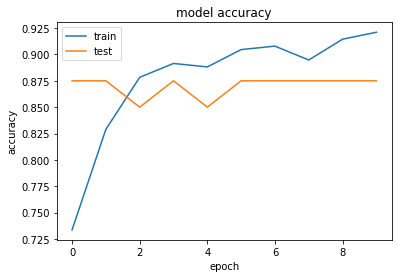

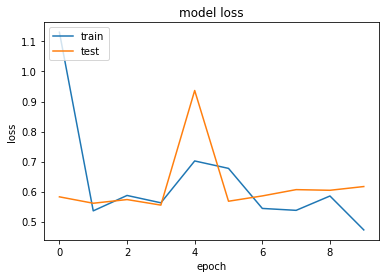

Fold nr.: 1
Epoch 1/10
304/304 [==============================] - 1s 3ms/step - loss: 0.9442 - binary_accuracy: 0.7368 - val_loss: 0.2776 - val_binary_accuracy: 0.9000
Epoch 2/10
304/304 [==============================] - 1s 3ms/step - loss: 0.9603 - binary_accuracy: 0.7928 - val_loss: 0.5658 - val_binary_accuracy: 0.9000
Epoch 3/10
304/304 [==============================] - 1s 3ms/step - loss: 0.7829 - binary_accuracy: 0.8553 - val_loss: 0.5572 - val_binary_accuracy: 0.8500
Epoch 4/10
304/304 [==============================] - 1s 3ms/step - loss: 0.7812 - binary_accuracy: 0.8322 - val_loss: 0.3182 - val_binary_accuracy: 0.8250
Epoch 5/10
304/304 [==============================] - 1s 3ms/step - loss: 0.8671 - binary_accuracy: 0.7862 - val_loss: 0.5431 - val_binary_accuracy: 0.8750
Epoch 6/10
304/304 [==============================] - 1s 3ms/step - loss: 0.7864 - binary_accuracy: 0.8355 - val_loss: 0.5329 - val_binary_accuracy: 0.8750
Epoch 7/10
304/304 [==============================] 

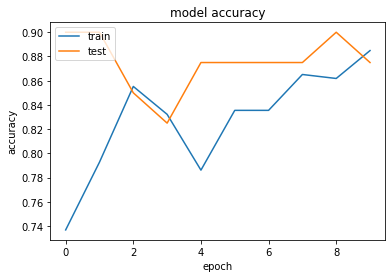

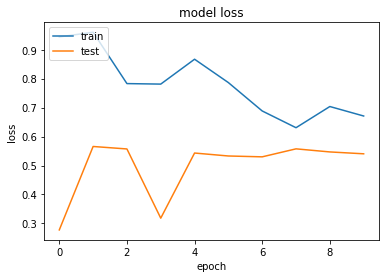

Fold nr.: 2
Epoch 1/10
304/304 [==============================] - 1s 3ms/step - loss: 3.7254 - binary_accuracy: 0.5428 - val_loss: 0.6795 - val_binary_accuracy: 0.4750
Epoch 2/10
304/304 [==============================] - 1s 3ms/step - loss: 1.8809 - binary_accuracy: 0.6118 - val_loss: 0.4668 - val_binary_accuracy: 0.8750
Epoch 3/10
304/304 [==============================] - 1s 3ms/step - loss: 0.8010 - binary_accuracy: 0.7072 - val_loss: 0.3695 - val_binary_accuracy: 0.8750
Epoch 4/10
304/304 [==============================] - 1s 3ms/step - loss: 0.7197 - binary_accuracy: 0.7730 - val_loss: 0.2841 - val_binary_accuracy: 0.9000
Epoch 5/10
304/304 [==============================] - 1s 3ms/step - loss: 0.8635 - binary_accuracy: 0.7961 - val_loss: 0.2723 - val_binary_accuracy: 0.8750
Epoch 6/10
304/304 [==============================] - 1s 3ms/step - loss: 0.6278 - binary_accuracy: 0.8322 - val_loss: 0.2531 - val_binary_accuracy: 0.9000
Epoch 7/10
304/304 [==============================] 

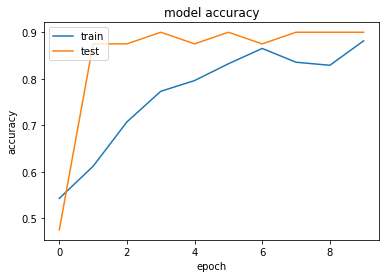

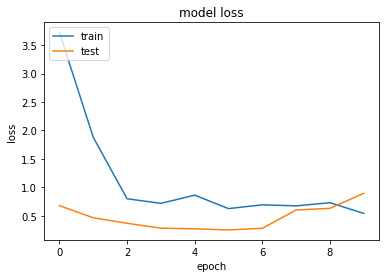

Fold nr.: 3
Epoch 1/10
304/304 [==============================] - 1s 3ms/step - loss: 1.3380 - binary_accuracy: 0.6316 - val_loss: 0.3517 - val_binary_accuracy: 0.8750
Epoch 2/10
304/304 [==============================] - 1s 3ms/step - loss: 0.8433 - binary_accuracy: 0.7928 - val_loss: 0.5662 - val_binary_accuracy: 0.9000
Epoch 3/10
304/304 [==============================] - 1s 3ms/step - loss: 0.7655 - binary_accuracy: 0.8684 - val_loss: 0.5649 - val_binary_accuracy: 0.8750
Epoch 4/10
304/304 [==============================] - 1s 3ms/step - loss: 0.6789 - binary_accuracy: 0.8586 - val_loss: 0.9444 - val_binary_accuracy: 0.8500
Epoch 5/10
304/304 [==============================] - 1s 3ms/step - loss: 0.6273 - binary_accuracy: 0.8684 - val_loss: 0.5788 - val_binary_accuracy: 0.8750
Epoch 6/10
304/304 [==============================] - 1s 3ms/step - loss: 0.5471 - binary_accuracy: 0.8914 - val_loss: 0.8827 - val_binary_accuracy: 0.9000
Epoch 7/10
304/304 [==============================] 

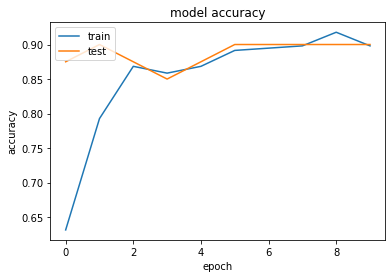

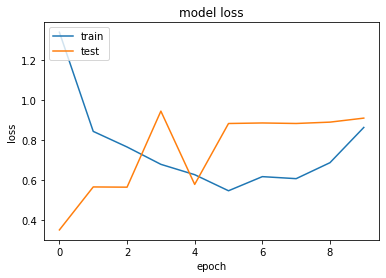

Fold nr.: 4
Epoch 1/10
304/304 [==============================] - 1s 3ms/step - loss: 2.7796 - binary_accuracy: 0.6480 - val_loss: 0.6928 - val_binary_accuracy: 0.8250
Epoch 2/10
304/304 [==============================] - 1s 3ms/step - loss: 0.6329 - binary_accuracy: 0.8289 - val_loss: 0.5878 - val_binary_accuracy: 0.8750
Epoch 3/10
304/304 [==============================] - 1s 3ms/step - loss: 0.7402 - binary_accuracy: 0.8849 - val_loss: 0.5911 - val_binary_accuracy: 0.8750
Epoch 4/10
304/304 [==============================] - 1s 3ms/step - loss: 0.5500 - binary_accuracy: 0.8980 - val_loss: 0.5849 - val_binary_accuracy: 0.8750
Epoch 5/10
304/304 [==============================] - 1s 3ms/step - loss: 0.5483 - binary_accuracy: 0.8553 - val_loss: 0.5952 - val_binary_accuracy: 0.8750
Epoch 6/10
304/304 [==============================] - 1s 3ms/step - loss: 0.5944 - binary_accuracy: 0.9046 - val_loss: 0.9299 - val_binary_accuracy: 0.9000
Epoch 7/10
304/304 [==============================] 

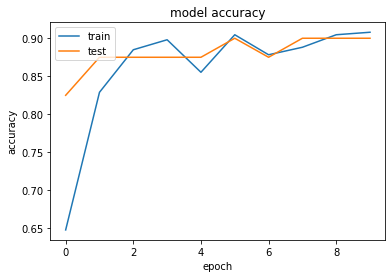

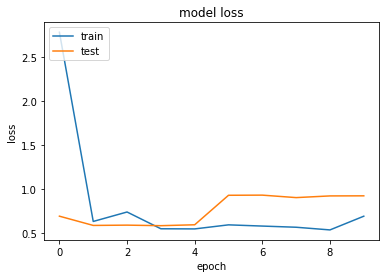



******************************************************


Over five folds AVG accuracy is: 0.9157894849777222


In [ ]:
input_size = 7
input_label_index = 7
t100_preds_results = []

X_test = test_set[:,0:input_size]
y_test =test_set [:,input_label_index]

for current_fold in range(0,fold_nr):
  print("Fold nr.:", current_fold)
  X_train = train_set[current_fold][:,0:input_size]
  #X_train = train_set[current_fold][:,[0,1,3]]
  y_train = train_set[current_fold][:,input_label_index]
  X_val = val_set[current_fold][:,0:input_size]
  #X_test = test_set[current_fold][:,[0,1,3]]
  y_val = val_set[current_fold][:,input_label_index]
  # define the keras model
  model = Sequential()
  #model.add(Dense(5, input_dim=input_size, activation='relu'))
  model.add(Dense(10, input_dim=input_size, activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(Dense(20, activation='relu'))
  model.add(layers.Dropout(0.4))
  model.add(Dense(1, activation='relu'))
  # compile the keras model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
  # fit the keras model on the dataset
  history = model.fit(X_train, y_train, epochs=10,validation_data=[X_test,y_test], batch_size=1)
  t100_preds_results.append(model.evaluate(X_val,y_val)[1])
  print("Accuracy on test set is: ", model.evaluate(X_test,y_test)[1])
  print("AVG Accuracy on Val and Test set is: ",(model.evaluate(X_test,y_test)[1]+model.evaluate(X_val,y_val)[1])/2)

  #model_en.summary()

  # evaluate the keras model
  #_, accuracy = model.evaluate(X_test, y_test)
  #print('Accuracy: %.2f' % (accuracy*100))

  import matplotlib.pyplot as plt
  # summarize history for accuracy
  plt.plot(history.history['binary_accuracy'])
  plt.plot(history.history['val_binary_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

print("\n\n******************************************************")
print("\n\nOver five folds AVG accuracy is:", str(sum(t100_preds_results)/5))

## Addestro T100 come SVM.

In [ ]:
input_size = 7
input_label_index = 7

SVM_T100_preds_results = []

X_test = test_set[:,0:input_size]
y_test = test_set [:,input_label_index]

for current_fold in range(0,3):
  print("Fold nr.:", current_fold)
  X_train = train_set[current_fold][:,0:input_size]
  #X_train = train_set[current_fold][:,[0,1,3]]
  y_train = train_set[current_fold][:,input_label_index]
  X_val = val_set[current_fold][:,0:input_size]
  #X_test = test_set[current_fold][:,[0,1,3]]
  y_val = val_set[current_fold][:,input_label_index]
  SVM_T100 = svm.SVC(C=1.0, kernel='rbf', gamma='auto')
  SVM_T100.fit(X_train,y_train)
  # predict the labels on training set
  #predictions_SVM = SVM.predict(training_samples)
  print("SVM Accuracy Score on Training set -> ",SVM_T100.score(X_train,y_train))

  print("SVM Accuracy Score on Val set -> ",SVM_T100.score(X_val,y_val))
  print("SVM Accuracy Score on Test set -> ",SVM_T100.score(X_test,y_test))
  SVM_T100_preds_results.append((SVM_T100.score(X_test,y_test)+SVM_T100.score(X_val,y_val))/2)
  print("SVM AVG Accuracy Score on Val and Test set -> ",(SVM_T100.score(X_test,y_test)+SVM_T100.score(X_val,y_val))/2)
  print("\n******************************************************")
print("\n\n******************************************************")
print("\n\nOver five folds AVG accuracy is:", str(sum(SVM_T100_preds_results)/5))

Fold nr.: 0
SVM Accuracy Score on Training set ->  0.930921052631579
SVM Accuracy Score on Val set ->  0.8552631578947368
SVM Accuracy Score on Test set ->  0.9
SVM AVG Accuracy Score on Val and Test set ->  0.8776315789473684

******************************************************
Fold nr.: 1
SVM Accuracy Score on Training set ->  0.9111842105263158
SVM Accuracy Score on Val set ->  0.8947368421052632
SVM Accuracy Score on Test set ->  0.9
SVM AVG Accuracy Score on Val and Test set ->  0.8973684210526316

******************************************************
Fold nr.: 2
SVM Accuracy Score on Training set ->  0.9177631578947368
SVM Accuracy Score on Val set ->  0.9473684210526315
SVM Accuracy Score on Test set ->  0.925
SVM AVG Accuracy Score on Val and Test set ->  0.9361842105263158

******************************************************


******************************************************


Over five folds AVG accuracy is: 0.5422368421052631


## Addestro T100 come Logistic Regressor.

In [ ]:
LR_T100_preds_results = []

X_test = test_set[:,0:input_size]
y_test =test_set [:,input_label_index]

for current_fold in range(0,fold_nr):
  print("Fold nr.:", current_fold)
  X_train = train_set[current_fold][:,0:input_size]
  #X_train = train_set[current_fold][:,[0,1,3]]
  y_train = train_set[current_fold][:,input_label_index]
  X_val = val_set[current_fold][:,0:input_size]
  #X_test = test_set[current_fold][:,[0,1,3]]
  y_val = val_set[current_fold][:,input_label_index]
  LR_T100 = LogisticRegression(random_state=0).fit(X_train, y_train)
  print("Logistic Regressor Accuracy Score on Training set -> ",LR_T100.score(X_train,y_train))

  # predict the labels on validation dataset
  #predictions_SVM = SVM.predict(test_samples)
  # Use accuracy_score function to get the accuracy
  #model_results[key][(fold_nr+1)]=SVM.score(test_samples,test_labels)
  print("Logistic Regressor Accuracy Score on Val set -> ",LR_T100.score(X_val,y_val))
  print("Logistic Regressor Accuracy Score on Test set -> ",LR_T100.score(X_test,y_test))
  print("LR AVG Accuracy Score on Val and Test set -> ",(LR_T100.score(X_test,y_test)+LR_T100.score(X_val,y_val))/2)
  LR_T100_preds_results.append((LR_T100.score(X_test,y_test)+LR_T100.score(X_val,y_val))/2)
  print("\n******************************************************")

print("\n\n******************************************************")
print("\n\nOver five folds AVG accuracy is:", str(sum(LR_T100_preds_results)/5))

Fold nr.: 0
Logistic Regressor Accuracy Score on Training set ->  0.9177631578947368
Logistic Regressor Accuracy Score on Val set ->  0.9210526315789473
Logistic Regressor Accuracy Score on Test set ->  0.925
LR AVG Accuracy Score on Val and Test set ->  0.9230263157894737

******************************************************
Fold nr.: 1
Logistic Regressor Accuracy Score on Training set ->  0.9111842105263158
Logistic Regressor Accuracy Score on Val set ->  0.9342105263157895
Logistic Regressor Accuracy Score on Test set ->  0.925
LR AVG Accuracy Score on Val and Test set ->  0.9296052631578948

******************************************************
Fold nr.: 2
Logistic Regressor Accuracy Score on Training set ->  0.9111842105263158
Logistic Regressor Accuracy Score on Val set ->  0.9342105263157895
Logistic Regressor Accuracy Score on Test set ->  0.925
LR AVG Accuracy Score on Val and Test set ->  0.9296052631578948

******************************************************
Fold nr.: 

## Addestro T100 come DecisionTree.

In [ ]:
DT_T100_preds_results = []
#input_size=5
#input_label_index = 5

X_test = test_set[:,0:input_size]
y_test =test_set [:,input_label_index]

for current_fold in range(0,fold_nr):
  print("Fold nr.:", current_fold)
  X_train = train_set[current_fold][:,0:input_size]
  #X_train = train_set[current_fold][:,[0,1,3]]
  y_train = train_set[current_fold][:,input_label_index]
  X_val = val_set[current_fold][:,0:input_size]
  #X_test = test_set[current_fold][:,[0,1,3]]
  y_val = val_set[current_fold][:,input_label_index]
  DT_T100 = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
  print("DT Accuracy Score on Training set -> ",DT_T100.score(X_train,y_train))

  print("DT Accuracy Score on Val set -> ",DT_T100.score(X_val,y_val))
  print("DT Accuracy Score on Test set -> ",DT_T100.score(X_test,y_test))
  DT_T100_preds_results.append((DT_T100.score(X_test,y_test)+DT_T100.score(X_val,y_val))/2)
  print("DT AVG Accuracy Score on Val and Test set -> ",(DT_T100.score(X_test,y_test)+DT_T100.score(X_val,y_val))/2)
  print("\n******************************************************")

print("\n\n******************************************************")
print("\n\nOver five folds AVG accuracy is:", str(sum(DT_T100_preds_results)/5))

Fold nr.: 0
DT Accuracy Score on Training set ->  1.0
DT Accuracy Score on Val set ->  0.8421052631578947
DT Accuracy Score on Test set ->  0.9
DT AVG Accuracy Score on Val and Test set ->  0.8710526315789473

******************************************************
Fold nr.: 1
DT Accuracy Score on Training set ->  1.0
DT Accuracy Score on Val set ->  0.8157894736842105
DT Accuracy Score on Test set ->  0.8
DT AVG Accuracy Score on Val and Test set ->  0.8078947368421052

******************************************************
Fold nr.: 2
DT Accuracy Score on Training set ->  1.0
DT Accuracy Score on Val set ->  0.8947368421052632
DT Accuracy Score on Test set ->  0.85
DT AVG Accuracy Score on Val and Test set ->  0.8723684210526316

******************************************************
Fold nr.: 3
DT Accuracy Score on Training set ->  1.0
DT Accuracy Score on Val set ->  0.8421052631578947
DT Accuracy Score on Test set ->  0.825
DT AVG Accuracy Score on Val and Test set ->  0.8335526315

## Addestro T100 come RandomForest.

In [ ]:
RF_T100_preds_results = []

X_test = test_set[:,0:input_size]
y_test =test_set [:,input_label_index]

for current_fold in range(0,fold_nr):
  print("Fold nr.:", current_fold)
  X_train = train_set[current_fold][:,0:input_size]
  #X_train = train_set[current_fold][:,[0,1,3]]
  y_train = train_set[current_fold][:,input_label_index]
  X_val = val_set[current_fold][:,0:input_size]
  #X_test = test_set[current_fold][:,[0,1,3]]
  y_val = val_set[current_fold][:,input_label_index]
  RF_T100 = RandomForestClassifier(max_depth=2, random_state=0).fit(X_train, y_train)
  
  print("RF Accuracy Score on Training set -> ",RF_T100.score(X_train,y_train))

  print("DT Accuracy Score on Val set -> ",RF_T100.score(X_val,y_val))
  print("DT Accuracy Score on Test set -> ",RF_T100.score(X_test,y_test))
  RF_T100_preds_results.append((RF_T100.score(X_test,y_test)+RF_T100.score(X_val,y_val))/2)
  print("DT AVG Accuracy Score on Val and Test set -> ",(RF_T100.score(X_test,y_test)+RF_T100.score(X_val,y_val))/2)
  print("\n******************************************************")

print("\n\n******************************************************")
print("\n\nOver five folds AVG accuracy is:", str(sum(RF_T100_preds_results)/5))

Fold nr.: 0
RF Accuracy Score on Training set ->  0.9210526315789473
DT Accuracy Score on Val set ->  0.9078947368421053
DT Accuracy Score on Test set ->  0.875
DT AVG Accuracy Score on Val and Test set ->  0.8914473684210527

******************************************************
Fold nr.: 1
RF Accuracy Score on Training set ->  0.9243421052631579
DT Accuracy Score on Val set ->  0.9342105263157895
DT Accuracy Score on Test set ->  0.9
DT AVG Accuracy Score on Val and Test set ->  0.9171052631578948

******************************************************
Fold nr.: 2
RF Accuracy Score on Training set ->  0.9210526315789473
DT Accuracy Score on Val set ->  0.9210526315789473
DT Accuracy Score on Test set ->  0.9
DT AVG Accuracy Score on Val and Test set ->  0.9105263157894736

******************************************************
Fold nr.: 3
RF Accuracy Score on Training set ->  0.9342105263157895
DT Accuracy Score on Val set ->  0.881578947368421
DT Accuracy Score on Test set ->  0.87

## Addestro T100 come GradientBoosting.

In [ ]:
GB_T100_preds_results = []

X_test = test_set[:,0:input_size]
y_test =test_set [:,input_label_index]

for current_fold in range(0,fold_nr):
  print("Fold nr.:", current_fold)
  X_train = train_set[current_fold][:,0:input_size]
  #X_train = train_set[current_fold][:,[0,1,3]]
  y_train = train_set[current_fold][:,input_label_index]
  X_val = val_set[current_fold][:,0:input_size]
  #X_test = test_set[current_fold][:,[0,1,3]]
  y_val = val_set[current_fold][:,input_label_index]
  GB_T100 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)
 
  print("DT Accuracy Score on Training set -> ",GB_T100.score(X_train,y_train))

  print("DT Accuracy Score on Val set -> ",GB_T100.score(X_val,y_val))
  print("DT Accuracy Score on Test set -> ",GB_T100.score(X_test,y_test))
  GB_T100_preds_results.append((GB_T100.score(X_test,y_test)+GB_T100.score(X_val,y_val))/2)
  print("DT AVG Accuracy Score on Val and Test set -> ",(GB_T100.score(X_test,y_test)+GB_T100.score(X_val,y_val))/2)
  print("\n******************************************************")

print("\n\n******************************************************")
print("\n\nOver five folds AVG accuracy is:", str(sum(GB_T100_preds_results)/5))


Fold nr.: 0
DT Accuracy Score on Training set ->  0.9572368421052632
DT Accuracy Score on Val set ->  0.881578947368421
DT Accuracy Score on Test set ->  0.875
DT AVG Accuracy Score on Val and Test set ->  0.8782894736842105

******************************************************
Fold nr.: 1
DT Accuracy Score on Training set ->  0.9572368421052632
DT Accuracy Score on Val set ->  0.9078947368421053
DT Accuracy Score on Test set ->  0.85
DT AVG Accuracy Score on Val and Test set ->  0.8789473684210527

******************************************************
Fold nr.: 2
DT Accuracy Score on Training set ->  0.9539473684210527
DT Accuracy Score on Val set ->  0.9210526315789473
DT Accuracy Score on Test set ->  0.85
DT AVG Accuracy Score on Val and Test set ->  0.8855263157894737

******************************************************
Fold nr.: 3
DT Accuracy Score on Training set ->  0.9736842105263158
DT Accuracy Score on Val set ->  0.868421052631579
DT Accuracy Score on Test set ->  0.8

# Generating predictions to submit on unlabelled test set.

In [ ]:
# Function to generate voters predictions.
def gen_voters_predictions(sample, best_fold):
  text_vect_layer_model = tf.keras.Model(inputs=cnn[best_fold].input,
                                          outputs=cnn[best_fold].get_layer(cnn[best_fold].get_layer(index=0).name).output)
  text_vect_out = text_vect_layer_model(sample)

  current_sample = np.zeros(max_features[best_fold])
  for current_token in text_vect_out[0][:].numpy():
      current_sample[current_token]+=1
      
  cnn_prediction = cnn[best_fold].predict(sample)
  predictions = [cnn_prediction[0][0],
                        NB[best_fold].predict_proba(current_sample.reshape(1,-1))[0][0],NB[best_fold].predict_proba(current_sample.reshape(1,-1))[0][1],
                        SVM[best_fold].predict_proba(current_sample.reshape(1,-1))[0][0],SVM[best_fold].predict_proba(current_sample.reshape(1,-1))[0][1],
                        DT[best_fold].predict_proba(current_sample.reshape(1,-1))[0][0],DT[best_fold].predict_proba(current_sample.reshape(1,-1))[0][1]]

  # Uncomment following line to normalize data.
  #predictions[:] = np.exp(predictions[:]/2)/(2*(np.cosh(predictions[:]/2)))

  return predictions


In [ ]:
## Generate predictions and write into separate XML files. (1 file -> 1 author prediction)

# msiino_iss2022task_predictions/en/aId.xml
if not os.path.exists('t100_iss2022task_predictions'):
    os.makedirs('t100_iss2022task_predictions')
if not os.path.exists('t100_iss2022task_predictions/en/'):
    os.makedirs('t100_iss2022task_predictions/en/')

prediction_counter=0
for filename in os.listdir('pan22-author-profiling-test-2022-04-22-without_truth-augmented/en/'):
    if filename!=".txt":
      prediction_counter+=1
      print("\nFile nr.: ", prediction_counter)
      
      x = filename.split(".")
      
      author_id = x[0]
      print("Filename:", filename)

      if not os.path.exists('tmp_test_author_dir/'+author_id):
        os.makedirs('tmp_test_author_dir/'+author_id)
      
      if os.path.exists('pan22-author-profiling-test-2022-04-22-without_truth-augmented/en/'+filename):
        shutil.copyfile('pan22-author-profiling-test-2022-04-22-without_truth-augmented/en/'+filename, 'tmp_test_author_dir/'+author_id+'/'+author_id+'.txt' )

      test_ds = tf.keras.preprocessing.text_dataset_from_directory(
        'tmp_test_author_dir', 
        batch_size=1,
        shuffle=False
        )
      
      for current_sample in test_ds:
        #print(current_sample[0])
        #print(current_sample[0])
        voters_predictions = np.array(gen_voters_predictions(current_sample[0],2)).reshape(1,-1)
        print(voters_predictions)
        LR_T100_prediction = LR_T100.predict(voters_predictions)
        print(LR_T100_prediction)
        if LR_T100_prediction[0]>0.0:
          prediction="I"
        else:
          prediction="NI"
        #prediction = model.predict_classes(current_sample)[0][0]
      print("Author id:",author_id)
      print("Language: en")
      print("Class predicted:", prediction)
      print("Model output: ", LR_T100_prediction)
      xml_content= "<author id=\"" + author_id + "\" lang=\"en\" type=\"" + str(prediction) + "\" />"

      f = open("t100_iss2022task_predictions/en/"+author_id+".xml", "a")
      f.write(xml_content)
      f.close()

      shutil.rmtree('tmp_test_author_dir/'+author_id)

## Zip and Download the predictions (remember to set Callback to use this!).

!zip -r t100_iss2022task_predictions.zip t100_iss2022task_predictions
# If automatic download doesn't start, open the directory browser on the left menu and download the zip file manually.
files.download("t100_iss2022task_predictions.zip")


File nr.:  1
Filename: 58e5bea5c4ed3b543ed1a4a8801aea2.xml
Found 1 files belonging to 1 classes.
[[1.45012579e+01 0.00000000e+00 1.00000000e+00 2.95861913e-07
  9.99999704e-01 0.00000000e+00 1.00000000e+00]]
[1.]
Author id: 58e5bea5c4ed3b543ed1a4a8801aea2
Language: en
Class predicted: I
Model output:  [1.]

File nr.:  2
Filename: aff307c6397a566f998178f78fc516a2.xml
Found 1 files belonging to 1 classes.
[[1.81131887e+000 1.56732538e-146 1.00000000e+000 1.64433021e-001
  8.35566979e-001 0.00000000e+000 1.00000000e+000]]
[1.]
Author id: aff307c6397a566f998178f78fc516a2
Language: en
Class predicted: I
Model output:  [1.]

File nr.:  3
Filename: 55cc89ad573fe23d444d76c1f091428b.xml
Found 1 files belonging to 1 classes.
[[2.38169594e+01 0.00000000e+00 1.00000000e+00 6.33539478e-13
  1.00000000e+00 0.00000000e+00 1.00000000e+00]]
[1.]
Author id: 55cc89ad573fe23d444d76c1f091428b
Language: en
Class predicted: I
Model output:  [1.]

File nr.:  4
Filename: b3ca53789d1f41d1fc0e6ebe2847b0c5.xml
F

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
## Generate predictions and write into separate XML files. (1 file -> 1 author prediction)

# msiino_iss2022task_predictions/en/aId.xml
if not os.path.exists('SVMBadJackPreds'):
    os.makedirs('SVMBadJackPreds')
if not os.path.exists('SVMBadJackPreds/en/'):
    os.makedirs('SVMBadJackPreds/en/')

prediction_counter=0
for filename in os.listdir('pan22-author-profiling-test-2022-04-22-without_truth-augmented/en/'):
    if filename!=".txt":
      prediction_counter+=1
      print("\nFile nr.: ", prediction_counter)
      
      x = filename.split(".")
      
      author_id = x[0]
      print("Filename:", filename)

      if not os.path.exists('tmp_test_author_dir/'+author_id):
        os.makedirs('tmp_test_author_dir/'+author_id)
      
      if os.path.exists('pan22-author-profiling-test-2022-04-22-without_truth-augmented/en/'+filename):
        shutil.copyfile('pan22-author-profiling-test-2022-04-22-without_truth-augmented/en/'+filename, 'tmp_test_author_dir/'+author_id+'/'+author_id+'.txt' )

      test_ds = tf.keras.preprocessing.text_dataset_from_directory(
        'tmp_test_author_dir', 
        batch_size=1,
        shuffle=False
        )
      
      for current_sample in test_ds:
        #print(current_sample[0])
        #print(current_sample[0])
        voters_predictions = np.array(gen_voters_predictions(current_sample[0],2)).reshape(1,-1)
        print(voters_predictions)
        SVM_T100_prediction = SVM_T100.predict(voters_predictions)
        print(SVM_T100_prediction)
        if SVM_T100_prediction[0]>0.0:
          prediction="I"
        else:
          prediction="NI"
        #prediction = model.predict_classes(current_sample)[0][0]
      print("Author id:",author_id)
      print("Language: en")
      print("Class predicted:", prediction)
      print("Model output: ", SVM_T100_prediction)
      xml_content= "<author id=\"" + author_id + "\" lang=\"en\" type=\"" + str(prediction) + "\" />"

      f = open("SVMBadJackPreds/en/"+author_id+".xml", "a")
      f.write(xml_content)
      f.close()

      shutil.rmtree('tmp_test_author_dir/'+author_id)

## Zip and Download the predictions (remember to set Callback to use this!).

!zip -r SVMBadJackPreds.zip SVMBadJackPreds
# If automatic download doesn't start, open the directory browser on the left menu and download the zip file manually.
files.download("SVMBadJackPreds.zip")


File nr.:  1
Filename: 58e5bea5c4ed3b543ed1a4a8801aea2.xml
Found 1 files belonging to 1 classes.
[[1.45012579e+01 0.00000000e+00 1.00000000e+00 2.95861913e-07
  9.99999704e-01 0.00000000e+00 1.00000000e+00]]
[1.]
Author id: 58e5bea5c4ed3b543ed1a4a8801aea2
Language: en
Class predicted: I
Model output:  [1.]

File nr.:  2
Filename: aff307c6397a566f998178f78fc516a2.xml
Found 1 files belonging to 1 classes.
[[1.81131887e+000 1.56732538e-146 1.00000000e+000 1.64433021e-001
  8.35566979e-001 0.00000000e+000 1.00000000e+000]]
[1.]
Author id: aff307c6397a566f998178f78fc516a2
Language: en
Class predicted: I
Model output:  [1.]

File nr.:  3
Filename: 55cc89ad573fe23d444d76c1f091428b.xml
Found 1 files belonging to 1 classes.
[[2.38169594e+01 0.00000000e+00 1.00000000e+00 6.33539478e-13
  1.00000000e+00 0.00000000e+00 1.00000000e+00]]
[1.]
Author id: 55cc89ad573fe23d444d76c1f091428b
Language: en
Class predicted: I
Model output:  [1.]

File nr.:  4
Filename: b3ca53789d1f41d1fc0e6ebe2847b0c5.xml
F

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>